# Date of observation in monthly median composites

In [1]:
%matplotlib inline

import datacube
import numpy as np
import sys
import xarray as xr

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

In [3]:
# Define area of interest
lat = -34.288 
lon = 20.012 
lon_buffer = 0.01
lat_buffer = 0.01

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01', '2018-12')

In [4]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['blue'],
    'resolution': (-20,20),
    'output_crs': 'epsg:6933'
}

# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query
              )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 130 time steps


In [5]:
def date_of_median(da, year, sample_lat, sample_lon):
    """
    da = xr.DataArray
        Assuming an annual time-series
    year = str
        year of time-series in 'da'
    sample_lat = float
        latitude pixel coordinate
    sample_lon = float
        longitude pixel coordinate
    
    """
    
    #calculate medians for each month
    monthly_medians = da.groupby('time.month').median()
    
    months = [str(i) for i in range(1,13)]
    indexes = [i for i in range(0,12)]
    
    dates=[]
    values=[]
    for month, index in zip(months,indexes): 
        
        #select the month of interest from da
        m = da.sel(time=year+"-"+month)
        
        #find regions with all-NaN slices
        mask = m.isnull().all('time')
        
        #calculate distance each pixel has from median
        distance = m - monthly_medians.isel(month=index)
        
        #index of the absolute minimum distance
        distance = distance.fillna(float(distance.max() + 1))
        distance=xr.ufuncs.fabs(distance)
        idx = distance.idxmin(dim='time', skipna=True).where(~mask)
        value = distance.sel(time=idx, method='nearest')
        values.append(value)
        dates.append(idx)
    
    #join into dataarray along new dimension
    dates = xr.concat(dates, "date of median")
    dist_from_median = xr.concat(values, 'dist_from_monthly_median')
    
    #select pixel
    dates = dates.sel(x=sample_lon, y=sample_lat, method='nearest')
    dist_from_median = dist_from_median.sel(x=sample_lon, y=sample_lat, method='nearest')
    
    return dates, dist_from_median

In [7]:
date_of_median, dist_from_median = date_of_median(ds.blue,
                                                  sample_lon=1929690.,
                                                  sample_lat=-4123870.,
                                                  year='2018')

In [10]:
print(date_of_median)

<xarray.DataArray 'time' (date of median: 12)>
array(['2018-01-11T08:47:59.000000000', '2018-02-10T08:47:44.000000000',
       '2018-03-12T08:42:31.000000000', '2018-04-11T08:49:44.000000000',
       '2018-05-06T08:43:48.000000000', '2018-06-05T08:47:44.000000000',
       '2018-07-10T08:41:38.000000000', '2018-08-09T08:42:00.000000000',
       '2018-09-13T08:39:37.000000000', '2018-10-08T08:39:28.000000000',
       '2018-11-12T08:49:45.000000000', '2018-12-22T08:49:38.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 6933
    x            float64 1.93e+06
    y            float64 -4.124e+06
    month        (date of median) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: date of median


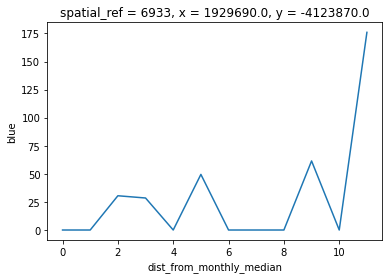

In [11]:
dist_from_median.plot()